# Predicting the Presence of Heart Disease in Cleveland: <br> Determining the Effects of Age, Sex, Cholesterol, and Heart Rate

## Introduction

Heart disease, also known as cardiovascular disease, is the top leading cause of death across the world, according to the [WHO](https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death). Heart disease refers to several heart-affecting conditions, with the most common condition causing blood vessels to narrow, restricting blood flow and potentially leading to heart attack.

The predictive question we wish to answer is: <br>
***“What key factors influence the presence of heart disease, and can we accurately diagnose heart disease based on age, sex, cholesterol levels and maximum heart rate?”***

Through data analysis, we will use the heart disease data set from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease), collected on June 30, 1988. This data set includes various observations from people in Cleveland, Hungary, Switzerland and the VA Long Beach. We will focus on the ***Cleveland data set*** to answer our question.


## Methods & Results

To predict the presence of heart disease in patients, we will use the K-Nearest Neighbors Classification algorithm to model and classify patients. To do this, we will follow the data science workflow:
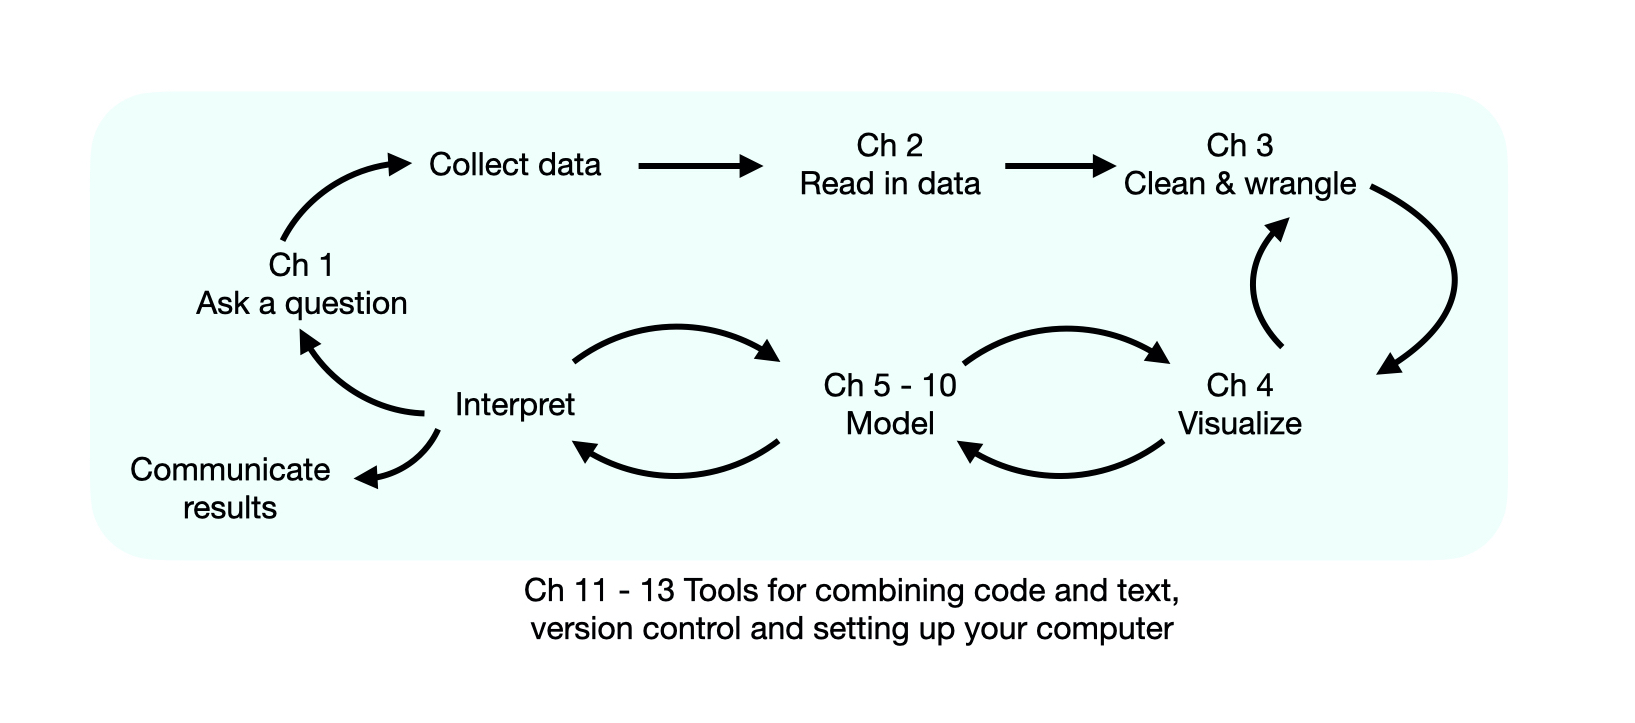
1. **Read** heart data
2. **Tidy, Clean & Wrangle** the data
3. **Visualize** predictors & relationships
4. **Model** the data and **Tune** our model
5. **Interpret** our Results

### Reading & Wrangling
First, we will load helpful packages, `tidyverse`, `tidymodels` and `RColorBrewer`, and read the `processed.cleveland.data` from the data set. The labels of the Cleveland data set columns are as follows:

1. age: age
2. sex: 0 = Female, 1 = Male
3. cp: chest pain type
4. trestbps: resting blood pressure (mmHg)
5. chol: cholesterol (mg/dL)
6. fbs: fasting blood sugar (1 = high, 0 = normal)
7. restecg: resting electrocardiographic results (0 = Normal, 1 = Abnormal, 2 = Likely Damage)
8. thalach: Maximum heart rate (beats/min) achieved in Intense Exercise
9. exang: exercise angina (1 = True, 0 = False)
10. oldpeak: ST depression by exercise
11. slope: slope of peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. ca: major vessels (#0-3)
13. thal: 3 = normal, 6 = fixed defect, 7 = reversable defect
14. num: diagnosis of heart disease

In [1]:
# Libraries/Packages to load
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# Reading the data from the web, adding column names
heart_data <- read_csv("https://raw.githubusercontent.com/Mr-Slope/DSCI-100_Group_Project/main/processed.cleveland.data",
                       col_names=c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                   "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
# Preview the data set
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In the data frame above, `ca` and `thal` are of type `<chr>` when they should be `<dbl>`. Since they did not automatically convert to the right data type, we will use `distinct()` to see if there are hidden character values in those columns.

In [3]:
select(heart_data, ca, thal) |>
distinct()

ca,thal
<chr>,<chr>
0.0,6.0
3.0,3.0
2.0,7.0
0.0,3.0
2.0,3.0
1.0,7.0
0.0,7.0
1.0,6.0
3.0,7.0


Above, we see that yes, the columns are `<chr>` because there are `?` values. We will filter these out, and convert the columns to `<dbl>` using `as.numeric`.

In addition, we know that `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca`, `thal`, and `num` should be `<fct>` instead of `<dbl>` based on the label descriptions. We will convert these columns as well. However, we will leave `sex` as numbers, because we plan to use it in a KNN-Classification model which requires numeric predictors.

Lastly, for convenience we will rename label values using `fct_recode()` based on the label descriptions to make them easier to interpret. 

In [4]:
# Cleaning & Wrangling
heart_tidy <- heart_data |>
    # filtering & converting labels ca & thal to <dbl>
    filter(ca != "?", thal != "?") |>
    mutate(across(c(ca, thal), as.numeric)) |>
    # coverting other labels to <fct>, omit sex
    mutate(across(c(cp, fbs, restecg, exang, slope, ca, thal, num), as_factor)) |>
    # renaming label values for convenience
    mutate(cp = fct_recode(cp, "angina" = "1", "abnormal" = "2", "nonang" = "3", "asymp" = "4")) |>
    mutate(fbs = fct_recode(fbs, "high" = "1", "norm" = "0")) |>
    mutate(restecg = fct_recode(restecg, "norm" = "0", "abnorm" = "1", "damage" = "2")) |>
    mutate(exang = fct_recode(exang, "TRUE" = "1", "FALSE" = "0")) |>
    mutate(slope = fct_recode(slope, "up" = "1", "flat" = "2", "down" = "3")) |>
    mutate(thal = fct_recode(thal, "norm" = "3", "fixed" = "6", "reversible" = "7")) |>
    mutate(num = fct_recode(num, "healthy" = "0", "sick" = "1", "sick" = "2", "sick" = "3", "sick" = "4")) |>
    # note: in the data, a num value of 1, 2, 3 or 4 are all considered "sick"
    tibble()
head(heart_tidy)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,angina,145,233,high,damage,150,FALSE,2.3,down,0,fixed,healthy
67,1,asymp,160,286,norm,damage,108,TRUE,1.5,flat,3,norm,sick
67,1,asymp,120,229,norm,damage,129,TRUE,2.6,flat,2,reversible,sick
37,1,nonang,130,250,norm,norm,187,FALSE,3.5,down,0,norm,healthy
41,0,abnormal,130,204,norm,damage,172,FALSE,1.4,up,0,norm,healthy
56,1,abnormal,120,236,norm,norm,178,FALSE,0.8,up,0,norm,healthy


### Exploratory Data Analysis

To begin answering our question, ***“What key factors influence the presence of heart disease, and can we accurately diagnose heart disease based on age, sex, cholesterol levels and maximum heart rate?”***, we will visualize the four properties of age, sex, cholesterol (`chol`) and maximum heart rate (`thalach`). We chose these four, because we wonder if there are variations in risk between young/old people, male/female, and whether or not cholesterol or maximum heart-rate are strong risk-factors for heart disease. 

In particular, we would like to see if an Older Male with Above-average Cholesterol (circulatory blockage) and Below-Average heart-rate (circulation difficulties) will be predicted to have Heart Disease, as these factors may increase the chance of restricted blood flow (blood vessel narrowing) and thus heart disease.

First, we will split the data and visualize the training set to create our model.

In [5]:
# Set the seed
set.seed(29)

# Splitting the data
heart_split <- initial_split(heart_tidy, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

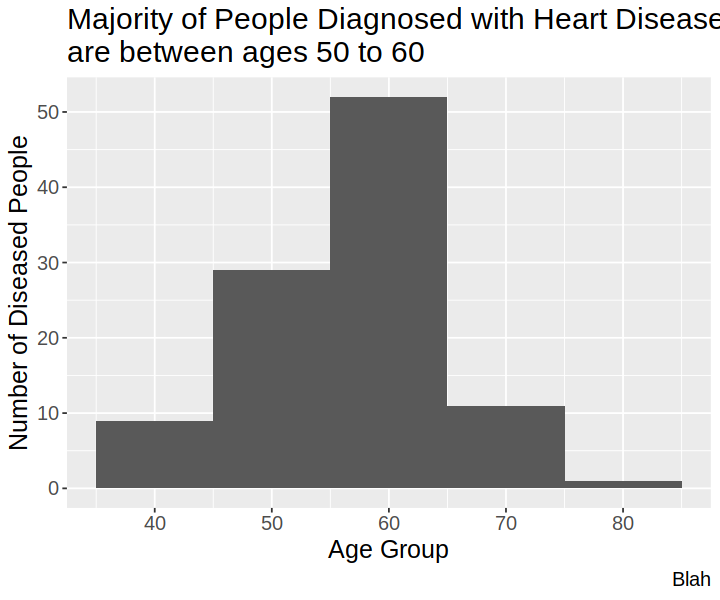

In [6]:
# Visualizations of Key Predictor Variables
options(repr.plot.width = 6, repr.plot.height = 5)

# Age (age) - Distribution of the number of sick people for all ages
age_viz <- heart_training |>
    select(age,num) |>
    filter(num=="sick") |>
    ggplot(aes(x=age)) +
    geom_histogram(binwidth=10) +
    ggtitle("Majority of People Diagnosed with Heart Disease \nare between ages 50 to 60") +
    labs(x = "Age Group", y = "Number of Diseased People", caption = "Blah") +
    theme(text=element_text(size=15))
age_viz

**Figure 1. Majority of people diagnosed with heart disease are between ages 50 to 60.** Histogram that represents distribution of diseased people within age groups. Unimodal distribution has a range of age groups from 40 to 80 and its center is in 60. 

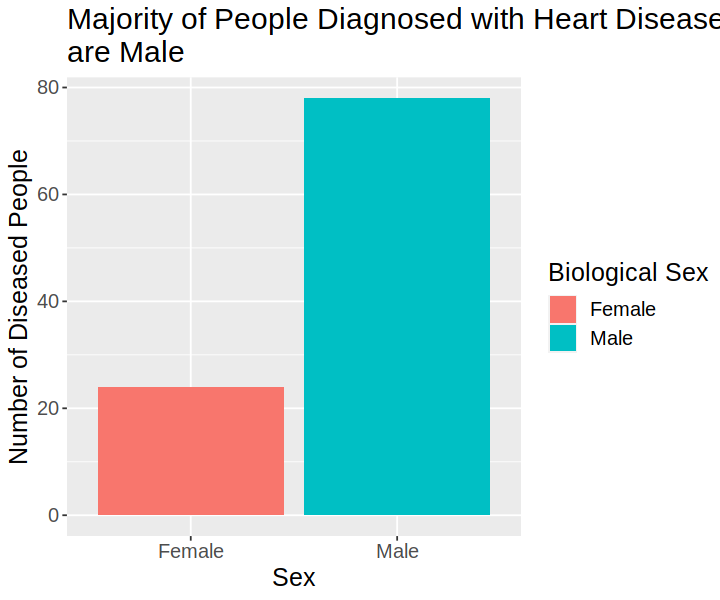

In [7]:
# Sex (sex) - Male & Female counts b/w Sick & Healthy
male_female <- heart_training |>
    select(sex,num) |>
    filter(num=="sick") |>
    mutate(sex=fct_recode(as_factor(sex), "Female"="0", "Male"="1")) |>
    ggplot(aes(x=sex,fill=sex)) +
    geom_bar(position="identity") +
    ggtitle("Majority of People Diagnosed with Heart Disease \nare Male") +
    labs(x="Sex",y="Number of Diseased People",fill="Biological Sex") +
    theme(text=element_text(size=15))
male_female

**Figure 2. Majority of people diagnosed with heart disease are male.** Bar graph that represents number of diseased people by their sex. Male has approximately 3 times higher number of diseased people compared to female. 

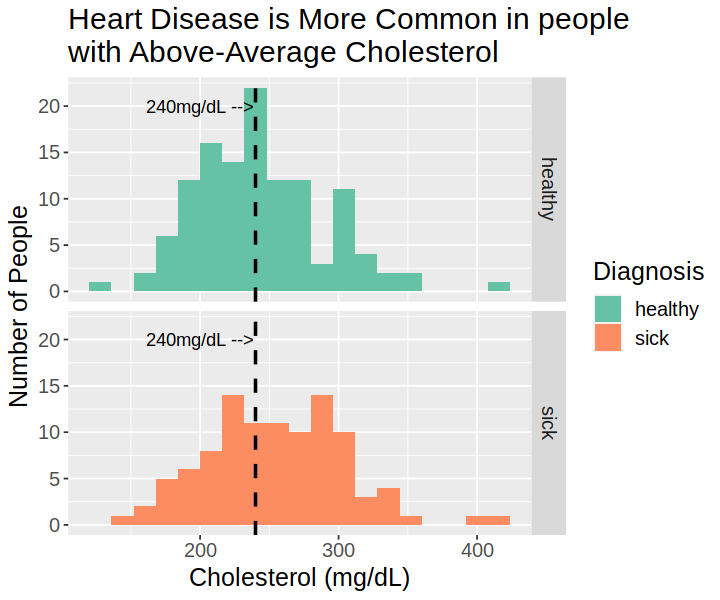

In [8]:
# Cholesterol (chol) - Higher cholesterol may lead to higher risk
chol_histogram <- heart_training |>
    ggplot(aes(x = chol, fill=num)) +
    geom_histogram(binwidth=16) +
    facet_grid(rows = vars(num)) +
    geom_vline(xintercept = 240, linetype = "dashed", linewidth = 1.0) +
    ggtitle("Heart Disease is More Common in people \nwith Above-Average Cholesterol") +    
    xlab("Cholesterol (mg/dL)") +
    ylab("Number of People") +
    labs(fill="Diagnosis") +
    annotate("text", x = 200, y = 20, label = "240mg/dL -->") +
    scale_fill_brewer(palette = "Set2") +
    theme(text=element_text(size=15))
chol_histogram

**Figure 3. Heart disease is more common in people with above average cholesterol.** Above average cholesterol is defined as 240mg/dL according to [Patient education: High cholesterol and lipids (Beyond the Basics) by Robert S Rosenson, MD](https://www.uptodate.com/contents/high-cholesterol-and-lipids-beyond-the-basics). Distribution of cholesterol (mg/dL) in two groups that are defined in two conditions (healthy and sick). 

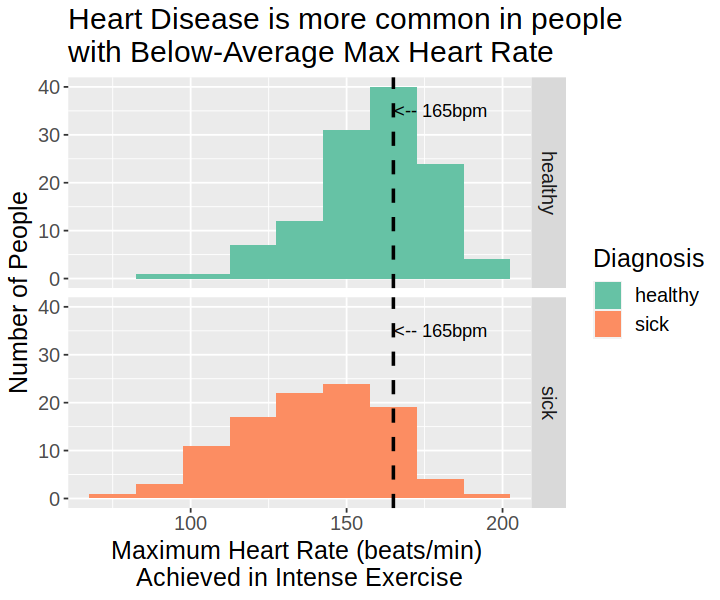

In [9]:
# Max Heartrate (thalach) - Below-average Heart Rate may increase risk
trestbps_histogram <- heart_training |>
    ggplot(aes(x = thalach, fill=num)) +
    geom_histogram(binwidth=15) +
    facet_grid(rows = vars(num)) +
    geom_vline(xintercept = 165, linetype = "dashed", linewidth = 1.0) +
    ggtitle("Heart Disease is more common in people \nwith Below-Average Max Heart Rate") +
    xlab("Maximum Heart Rate (beats/min) \nAchieved in Intense Exercise") +
    ylab("Number of People") +
    labs(fill="Diagnosis") +
    annotate("text", x = 180, y = 35, label = "<-- 165bpm") +
    scale_fill_brewer(palette = "Set2") +
    theme(text=element_text(size=15)) 
trestbps_histogram

**Figure 4. Heart disease is more common in people with below average max heart rate.** Distribution with maximum heart rate achieved in intense exercise in two conditions (healthy and sick). The Dotted line represents average max heart rate for the mean age of 55 (165bpm) according to [TopEnd Sports](https://www.topendsports.com/testing/heart-rate-max.htm).


### Modeling & Tuning

With our 4 main predictors explored, we will now create our K-Nearest Neighbors Classification model. We will use the same seed set above, and the same splits to perform:
1. Cross-validation to determine ideal K-values for given predictor(s)
2. Tuning with Best K-values 
3. Metric Collection of Accuracy, Precision & Recall

We attempted all possible combinations of `age`, `sex`, `chol` and `thalach`. Below, we include models that produce the best Accuracy, best Precision, best Recall, and a model predicting with `sex` alone, which produces the lowest in all three metrics.

For all models, we first create model specifications for KNN-Classification, using rectangular (Euclidean) line distance weighting, and neighbors set to tune. We then create a `5-fold cross-validation table` to get an average out of the sampled data, in order to find the best number of neighbors (k) that has the shortest average distance to its surrounding points. We also create a list/sequence of numbers from 1-100 to test as k-values. *NOTE: testing every k-value from 1-100 takes a long time.*

The model with the best `Accuracy` and `Precision` comes from `sex`,`chol`,and `thalach`. We center & scale the predictors of `sex`,`chol`,and `thalach` on the training data, `heart_training`. Lastly, we create a `workflow`, adding the recipe, model and tuning for numbers between 1-100, collecting the metrics.

In [10]:
# Highest Accuracy & Precision - Sex & Chol & Thalach

# Tuning for K
heart_tune <- nearest_neighbor(weight="rectangular", neighbors=tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Cross-validation
heart_vfold <- vfold_cv(heart_training, v = 5, strata = num)
gridvals <- tibble(neighbors = seq(1,100,1))

heart_recipe_sct <- recipe(num ~ sex + chol + thalach, data = heart_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

heart_tune_sct <- workflow() |>
    add_recipe(heart_recipe_sct) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics()
head(heart_tune_sct)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5986869,5,0.03190888,Preprocessor1_Model001
1,roc_auc,binary,0.5935714,5,0.03386764,Preprocessor1_Model001
2,accuracy,binary,0.5986869,5,0.03190888,Preprocessor1_Model002
2,roc_auc,binary,0.6404365,5,0.02886613,Preprocessor1_Model002
3,accuracy,binary,0.6664646,5,0.02684884,Preprocessor1_Model003
3,roc_auc,binary,0.6824901,5,0.02225745,Preprocessor1_Model003


We then filter by accuracy, arrange by the highest accuracy (descending `mean`), and take the first row and pull the best k-value.

In [13]:
heart_fit_sct_best_k <- heart_tune_sct |>
    select(neighbors, mean, .metric) |>
    filter(.metric == "accuracy") |>
    arrange(-mean) |>
    slice(1) |>
    select(neighbors) |>
    pull()
heart_fit_sct_best_k

[1] 35

With the best K-value of `35`, we complete the model again, creating a specification with the new k-value, and fitting the training data to the recipe and specifications. Finally, we predict on the `heart_testing` data, combining the tables with `bind_col` and collecting metrics. 

Precision and Recall are found from a confusion matrix, with Precision = TP/(TP+FP), or n_truly_sick/(n_truly_sick + n_overlooked_sick), and Recall = TP/(TP+FN), or n_truly_sick/(n_truly_sick + n_falsely_diagnosed_sick).

In [16]:
heart_spec_sct <- nearest_neighbor(weight="rectangular", neighbors=heart_fit_sct_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit_sct <- workflow() |>
    add_recipe(heart_recipe_sct) |>
    add_model(heart_spec_sct) |>
    fit(heart_training) 

heart_pred_sct <- heart_fit_sct |>
    predict(heart_testing) |>
    bind_cols(heart_testing) 
# Accuracy
heart_pred_sct_metrics <- heart_pred_sct |>
    metrics(truth = num, estimate=.pred_class) |>
    filter(.metric == "accuracy")
heart_pred_sct_metrics

# Confusion Matrix
heart_pred_sct_conf <- heart_pred_sct |>
    conf_mat(truth=num,estimate=.pred_class)
heart_pred_sct_conf

# with Sick being the True Positive
heart_sct_precision <- 24/(24+5) # Precision = TP/(TP+FP)
heart_sct_precision
heart_sct_recall <- 24/(24+11) # Recall = TP/(TP+FN)
heart_sct_recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7866667


          Truth
Prediction healthy sick
   healthy      35   11
   sick          5   24

[1] 0.8275862

[1] 0.6857143

We get an Accuracy of `78.7%`, a Precision of `82.8%`, and a Recall of `68.6%` for `sex`,`chol`,and `thalach`.

### Results

To better summarize our results, we will create tables of all the predictor combinations for their Accuracy, Precision and Recall percentages. Then, we will arrange them in order, and plot them to see which predictors perform the best.

In [101]:
metrics_table <- tibble(predictor = c("Age", "Age and Sex", "Age, Sex and Cholestrol", "Age, Sex, Cholesterol and Max-Heartrate",
                                      "Max-Heartrate","Sex and Cholesterol","Cholesterol and Max-Heartrate","Sex, Cholesterol and Max-Heartrate",
                                      "Cholesterol","Age and Cholesterol", "Age and Max-Heartrate", "Age, Cholesterol and Max-Heartrate",
                                      "Sex", "Sex and Max-Heartrate", "Age, Sex and Max-Heartrate"),
                        accuracy = c(74.7, 77.3, 62.7, 74.7,
                                     73.3,64.0,69.3,78.7,
                                     53.3,68.0,73.3,68.0,
                                     53.3,77.3,72.0),
                        precision = c(75.6,78.0,63.6,72.3,
                                      74.2,72.2,68.8,82.8,
                                      50.0,67.7,74.2,66.7,
                                      NaN,82.1,71.9),
                        recall = c(77.5,80.0,70.0,85.0,
                                   65.7,37.1,62.9,68.6,
                                   45.7,60.0,65.7,62.9,
                                   0.0,65.7,65.7))
                         
metrics_table

predictor,accuracy,precision,recall
<chr>,<dbl>,<dbl>,<dbl>
Age,74.7,75.6,77.5
Age and Sex,77.3,78.0,80.0
"Age, Sex and Cholestrol",62.7,63.6,70.0
"Age, Sex, Cholesterol and Max-Heartrate",74.7,72.3,85.0
Max-Heartrate,73.3,74.2,65.7
Sex and Cholesterol,64.0,72.2,37.1
Cholesterol and Max-Heartrate,69.3,68.8,62.9
"Sex, Cholesterol and Max-Heartrate",78.7,82.8,68.6
Cholesterol,53.3,50.0,45.7


From the table, we noted that predicting the presence of Heart Disease using Sex (another binary class) led to no Precision (0/0 = NaN) and no Recall (0/35 = 0), and an accuracy of 53.3%. In other words, Sex a very bad predictor alone, so we remove it from the visualizations below.

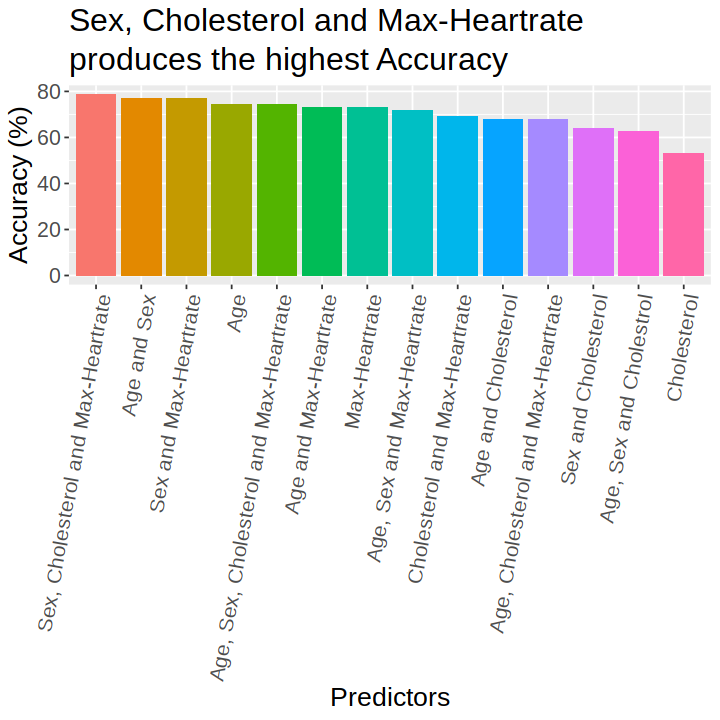

In [89]:
options(repr.plot.width = 6, repr.plot.height = 6)

metrics_clean <- metrics_table |>
    filter(predictor != "Sex")
accuracy_plot <- metrics_clean |>
    ggplot(aes(x = fct_reorder(predictor, accuracy, .desc=TRUE), 
               y = accuracy, 
               fill = fct_reorder(predictor, accuracy, .desc=TRUE))) +
    geom_bar(stat = "identity") +
    labs(x = "Predictors", y = "Accuracy (%)") +
    ggtitle("Sex, Cholesterol and Max-Heartrate \n
produces the highest Accuracy") +
    theme(text=element_text(size = 16), 
          axis.text.x = element_text(angle = 80, hjust = 1),
          plot.title = element_text(lineheight=0.5)) + 
    guides(fill = "none")
accuracy_plot

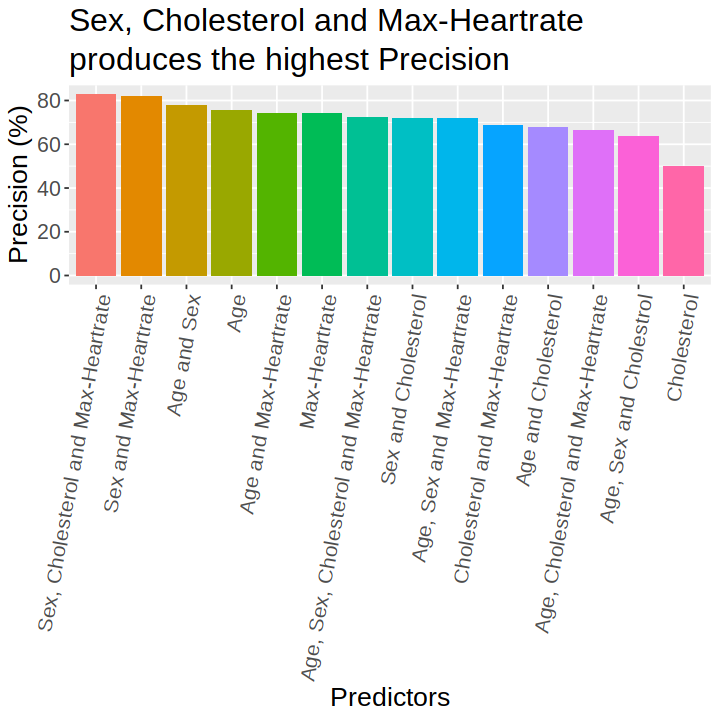

In [87]:
precision_plot <- metrics_clean |>
    ggplot(aes(x = fct_reorder(predictor, precision, .desc=TRUE), 
               y = precision, 
               fill = fct_reorder(predictor, precision, .desc=TRUE))) +
    geom_bar(stat = "identity") +
    labs(x = "Predictors", y = "Precision (%)") +
    ggtitle("Sex, Cholesterol and Max-Heartrate \n
produces the highest Precision") +
    theme(text=element_text(size = 16), 
          axis.text.x = element_text(angle = 80, hjust = 1),
          plot.title = element_text(lineheight=0.5)) + 
    guides(fill = "none")
precision_plot

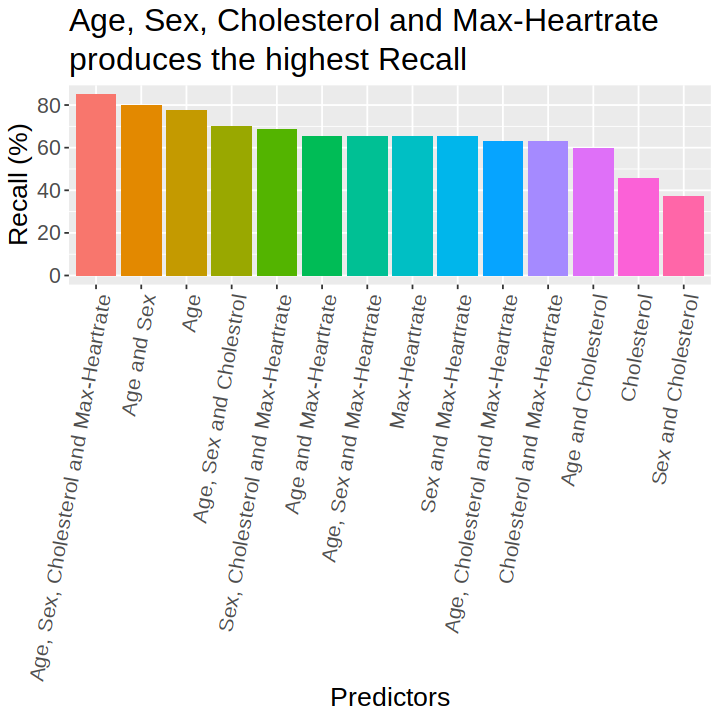

In [88]:
recall_plot <- metrics_clean |>
    ggplot(aes(x = fct_reorder(predictor, recall, .desc=TRUE), 
               y = recall, 
               fill = fct_reorder(predictor, recall, .desc=TRUE))) +
    geom_bar(stat = "identity") +
    labs(x = "Predictors", y = "Recall (%)") +
    ggtitle("Age, Sex, Cholesterol and Max-Heartrate \n
produces the highest Recall") +
    theme(text=element_text(size = 16), 
          axis.text.x = element_text(angle = 80, hjust = 1),
          plot.title = element_text(lineheight=0.5)) + 
    guides(fill = "none")
recall_plot

From the graphs, we find that the combination of `sex`+`chol`+`thalach`(max-heartrate) produces the highest Accuracy and Precision. However, the combination of `age`+`sex`+`chol`+`thalach` produces the highest recall.

## Discussion

From our data, the worst predictors are ...
The predictors with the strongest link to heart disease are...
We think the best factors to predict the presence of heart disease are ...
Recall is ... 
Recall is more important than Accuracy and Precision because ...

We expected/did not expect to find that...

Sources of uncertainty come from setting the seed to take random samples, which we attempted to minimize using cross-validation, however, can still change results. This could be further minimized by testing more models across more seeds.

Moving forward, these findings could be used to ...

Future questions...


## References



Creators of the heart data base are:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.


PROOFREADING: 
- all tables and figure should have a figure/table number and a legend
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.
- Word count < 2000 markdown cells excluding citations
- rubric